In [1]:
import warnings
import numpy as np
import pandas as pd
import catboost

from catboost import cv, Pool
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [30]:
days_from_start = {
    1: 0, 2: 31, 3: 59, 4: 90, 5: 120, 6: 151, 7: 181,
    8: 212, 9: 243, 10: 273, 11: 304, 12: 334
}

days_in_month = {1: 32, 2: 30, 3: 32, 4: 31, 5: 32, 6: 31,
                 7: 32, 8: 32, 9: 31, 10: 32, 11: 31, 12: 32
                 }

to_weekend = {1: 0, 2:0, 3: 0, 4: 0, 5: 0, 6:1, 7:1}

def create_period_faetures(value, period):
    value = value * 2 * np.pi
    return np.sin(value/period), np.cos(value/period)

def change_data(data):
    
    for name in "Month DayofMonth DayOfWeek".split():
        data[name] = data[name].str[2:].astype('int')
        
    
    data.DepTime = (data.DepTime % 2400)
    
    data["Year"] = 2018
    data["day"] = data.DayofMonth
    data["hour"] = data.DepTime // 100
    data["minutes"] = data.DepTime % 100
    # data["date_time"] = pd.to_datetime(data[['Year', "Month", "day", "hour", "minutes"]])
    
    data["dep_in_minutes"] = data.hour * 60 + data.minutes
    data["day_year"] = (data.Month.map(days_from_start) + data.DayofMonth) * 24
    
    data.drop(["Year", "day"], axis=1, inplace=True)
    
    data["weekend"] = data.DayOfWeek.map(to_weekend)
    
    data['sin_dep'], data['cos_dep'] = create_period_faetures(data.dep_in_minutes, 24 * 60)
    data['sin_year'], data['cos_year'] = create_period_faetures(data.day_year, 365 * 24)
    
    
    data.Distance = data.Distance.apply(np.log10) ** 2
    for name in "Month DayofMonth DayOfWeek".split():
        data[name] = data[name].astype(str)

**Read the data**

In [31]:
train_df = pd.read_csv('../../data/flight_delays_train.csv')
test_df = pd.read_csv('../../data/flight_delays_test.csv')

train_df.dep_delayed_15min = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0})

In [6]:
train_df['flight'] = train_df['Origin'] + ' --> ' + train_df['Dest']
test_df['flight'] = test_df['Origin'] + ' --> ' + test_df['Dest']

In [32]:
change_data(train_df)
change_data(test_df)

In [33]:
names = "DepTime hour	minutes	dep_in_minutes day_year".split()
drop = lambda x, y: x.drop(y, axis=1, inplace=True)
for data in (train_df, test_df):
    drop(data, names)
    

In [34]:
train_df.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,weekend,sin_dep,cos_dep,sin_year,cos_year
0,8,21,7,AA,ATL,DFW,8.205424,0,1,-0.917060,0.398749,-0.763889,-0.645348
1,4,20,3,US,PIT,MCO,8.533211,0,0,-0.838671,-0.544639,0.948362,-0.317191
2,9,2,5,XE,RDU,CLE,6.859650,0,0,-0.580703,-0.814116,-0.880012,-0.474951
3,11,25,6,OO,DEN,MEM,8.646637,0,1,0.442289,-0.896873,-0.580800,0.814046
4,10,7,6,WN,MDW,OMA,6.897664,1,1,-0.992546,0.121869,-0.994218,0.107381


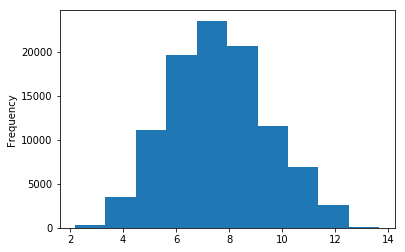

In [35]:
train_df.Distance.plot.hist()

In [433]:
num_feat = np.where(train_df.dtypes != 'object')[0]
num_feat.shape

(7,)

In [391]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

In [387]:
x_data_kbest = SelectKBest(f_classif, k=12).fit_transform((train_df.iloc[:, num_feat]).drop(["dep_delayed_15min"], axis=1),
                                                          train_df.dep_delayed_15min)

In [36]:
train_df.corr()

,Distance,dep_delayed_15min,weekend,sin_dep,cos_dep,sin_year,cos_year
Distance,1.000000,0.010600,0.014634,0.037693,-0.011059,-0.001079,-0.002247
dep_delayed_15min,0.010600,1.000000,-0.015949,-0.216927,0.166761,-0.009743,-0.005796
weekend,0.014634,-0.015949,1.000000,-0.007235,-0.018228,-0.004273,0.003139
sin_dep,0.037693,-0.216927,-0.007235,1.000000,-0.324402,-0.000449,0.001300
cos_dep,-0.011059,0.166761,-0.018228,-0.324402,1.000000,0.004394,-0.007182
sin_year,-0.001079,-0.009743,-0.004273,-0.000449,0.004394,1.000000,0.000178
cos_year,-0.002247,-0.005796,0.003139,0.001300,-0.007182,0.000178,1.000000


In [37]:
pd.DataFrame(x_data_kbest).head()

NameError: name 'x_data_kbest' is not defined

In [38]:
train_df.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,weekend,sin_dep,cos_dep,sin_year,cos_year
0,8,21,7,AA,ATL,DFW,8.205424,0,1,-0.917060,0.398749,-0.763889,-0.645348
1,4,20,3,US,PIT,MCO,8.533211,0,0,-0.838671,-0.544639,0.948362,-0.317191
2,9,2,5,XE,RDU,CLE,6.859650,0,0,-0.580703,-0.814116,-0.880012,-0.474951
3,11,25,6,OO,DEN,MEM,8.646637,0,1,0.442289,-0.896873,-0.580800,0.814046
4,10,7,6,WN,MDW,OMA,6.897664,1,1,-0.992546,0.121869,-0.994218,0.107381


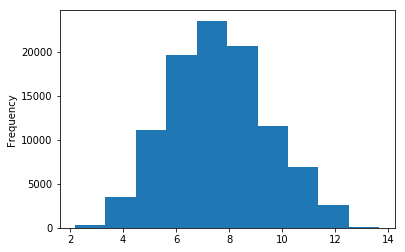

In [39]:
train_df.Distance.plot.hist()

---
---
---

In [40]:
categ_feat_idx = np.where(train_df.dtypes.drop(["dep_delayed_15min"]) == 'object')[0]
# categ_feat_idx = sorted(np.append(categ_feat_idx, [0, 1, 2]))
print(categ_feat_idx)

[0 1 2 3 4 5]


In [41]:
X_train = train_df.drop('dep_delayed_15min', axis=1).values
y_train = train_df['dep_delayed_15min'].values
X_test = test_df.values

In [42]:
X_train_part, X_valid, \
y_train_part, y_valid = train_test_split(X_train, y_train,
                                         test_size=0.3,
                                         random_state=17,
                                         shuffle=True
                                         )
                                        

In [43]:
ctb = CatBoostClassifier(random_seed=17, silent=True)

#### Train

In [44]:
%%time
ctb.fit(X_train_part,
        y_train_part, 
        cat_features=categ_feat_idx);

Wall time: 1min 18s


In [45]:
ctb_valid_pred = ctb.predict_proba(X_train_part)[:, 1]
print(roc_auc_score(y_train_part, ctb_valid_pred))

ctb_valid_pred = ctb.predict_proba(X_valid)[:, 1]
print(roc_auc_score(y_valid, ctb_valid_pred))

0.8467361392280801
0.7560353705113839


K Fold

In [295]:
test_score = []
train_score = []
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

i = 0
for test_index, train_index in skf.split(X_train, y_train):
    
    X_train_1, X_test_1 = X_train[train_index, :], X_train[test_index, :]
    y_train_1, y_test_1 = y_train[train_index], y_train[test_index]
    
    
    _ctb = CatBoostClassifier(random_seed=17,
                              silent=True
                             ).fit(X_train_1, y_train_1, cat_features=categ_feat_idx)
    
    test_score.append(roc_auc_score(y_test_1,
                                    _ctb.predict_proba(X_test_1)[:, 1]
                                   )
                     )
    train_score.append(roc_auc_score(y_train_1, _ctb.predict_proba(X_train_1)[:, 1]))
    
    i += 1
    print(i)
    

1
2
3


In [297]:
print(np.mean(test_score))
print(test_score)
print()
print(np.mean(train_score))
print(train_score)

0.733257522282691
[0.7340427864660044, 0.7342698581259834, 0.7314599222560852]

0.7764956099562351
[0.77261243910411, 0.7760086760842536, 0.7808657146803418]


params = \
{
# "iterations": 100,
"eval_metric": "AUC",
"verbose": False
#"devices": -1
}

pool = Pool(data=X_train,
            label=y_train,
            cat_features=categ_feat_idx)

scores = cv(pool,
            params=params,
            fold_count=5,
            plot="True",
            early_stopping_rounds=50)

----
----
----

Result

In [46]:
%%time
ctb.fit(X_train, y_train,
        cat_features=categ_feat_idx);

Wall time: 1min 40s


In [47]:
ctb_test_pred = ctb.predict_proba(X_test)[:, 1]

In [49]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sample_sub = pd.read_csv('../../data/sample_submission.csv', 
                             index_col='id')
    sample_sub['dep_delayed_15min'] = ctb_test_pred
    sample_sub.to_csv('ctb_pred_4.csv')

In [123]:
!head ctb_pred.csv

id,dep_delayed_15min
0,0.029813427154851885
1,0.045432589326845726
2,0.07735792880819185
3,0.26298352270959774
4,0.23812453664806577
5,0.1015030549268571
6,0.040331757718181545
7,0.2408800371330324
8,0.11304498960469873


In [127]:
!head ctb_pred_3.csv

id,dep_delayed_15min
0,0.025572166172376693
1,0.045981976846112715
2,0.07101399403966373
3,0.2905628227350732
4,0.2716783001872599
5,0.08292537325175686
6,0.04404007262086365
7,0.19666702216697723
8,0.07454022433182766


In [50]:
!head ctb_pred_4.csv

id,dep_delayed_15min
0,0.036572825023038706
1,0.04967646340966661
2,0.04485711620040537
3,0.2790975270111142
4,0.2463003053648039
5,0.09189481274496254
6,0.052521796588501285
7,0.17758909138474377
8,0.10541719657758256
